# 特徴選択(feature selection)
> 機械学習と統計学の用語であり、頑健な学習モデルの構築のため、特徴集合のうち意味のある部分集合だけを選択する手法のことを指す。**特徴量選択**、**変数選択**、**特徴削減**、**属性選択**、**素性選択**、**(変数)部分集合選択**などとも呼ばれる。不要で冗長な特徴量をデータから除去することによって、特徴選択は学習モデルを次の点で改善する：

> - **<font color="blue">学習を高速化する</font>**
> - **<font color="blue">過学習を減らす</font>**
> - **<font color="blue">モデルの可読性を改善する</font>**
> - **<font color="blue">モデルの精度が向上する</font>**
>
> 特徴選択を行うと、データのうちどの特徴量が重要でありどのようにそれらが関係しているかなどといった点について、人間が理解しやすくなるという効果もある。

**参考文献**
> [API Reference — scikit-learn 0.20.0 documentation # sklearn.feature_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)

In [17]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [95]:
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams["font.size"] = 18

---
# フィルター法(Filter Method)

<table align="left">
	<tr>
       <td><b>what</b></td>
		<td> 説明変数と目的変数の間に統計的に有意な関係があるかどうかにもとづいて選択する方法。<br>しかし、多くのフィルター法は最も良い部分集合を返すよりも、各特徴量のスコアをランキングした形式で返すことが多い</td>
	</tr>
	<tr>
       <td rowspan="3"><b>利用場面</b></td>
		<td align="left">①特徴量が多すぎてモデルを作ることができない場合<br>→必要な特徴量を抽出するよりも、不必要な特徴量を排除したい場合に有効</td>
	</tr>
	<tr>
		<td>②多くの特徴量が全く関係ないと思われるような場合に有効</td>
	</tr>
   <tr>
       <td>③ラッパー法の前処理として使われることある</td>
   </tr>
	<tr>
		<td><b>メリット</b></td>
		<td>学習・予測処理を伴わないのでラッパー法と比べて非常に高速</td>
	</tr>
	<tr>
		<td rowspan="2"><b>デメリット</b></td>
		<td align="left">指標の改善を確認してない. </td>
	</tr>
	<tr>
		<td align="left">個々の特徴量を個別に考慮するため,他の特徴量と組み合わさって意味を持つような特徴量は捨てられる.</td>
	</tr>
	<tr>
		<td><b>別名</b></td>
		<td><b>単変量統計</b>,<b>単変量選択</b></td>
	</tr>
	<tr>
		<td><b>注意</b></td>
		<td>フィルター法では、<b>多重共線性</b>を取り除くことはできないので注意が必要</td>
	</tr>
</table>

| 特徴量(説明変数)\予測値(目的変数) | 連続値 | 離散値(カテゴリー変数) |
|:-------------------------------------------:|:--------:|:--------------------------:|
| 連続値 | ピアソン相関係数 | LDA(線形判別解析) |
| 離散値(カテゴリー変数) | Anova(分散分析) | カイ二乗 |

## 分散の少ない特徴量の削除
[VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#sklearn.feature_selection.VarianceThreshold)は、特徴量選択に対する簡単なベースラインアプローチです。分散がある閾値を満たさないすべての特徴量を削除します。デフォルトでは、すべてのゼロ分散特徴量、つまりすべてのサンプルで同じ値を持つ特徴量が削除されます。<br>

たとえば、boolean値の特徴量を持つデータセットがあり、サンプルの80％以上で1またはゼロ（オンまたはオフ）の特徴量をすべて削除したいとします。boolean関数はベルヌーイの確率変数であり、このような変数の分散は

$$
\mathrm {Var}\left[X\right] = p\left( 1 - p \right)
$$

となる。したがって、閾値`0.8 * (1 - 0.8)`を使用して選択することができます。

In [156]:
X = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]])
X

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 1],
       [0, 1, 0],
       [0, 1, 1]])

↑予想では、最初の列が削除される。この列はゼロを含む確率`p=5/6>.8`です。

In [164]:
from sklearn.feature_selection import VarianceThreshold


threshold = (0.8 * (1 - .8))
sel = VarianceThreshold(threshold=threshold)
sel.fit(X)

print('分散値 : ', sel.variances_)
print('選択された変数(閾値よりも分散値が多い変数) : ', sel.get_support(indices=False))   # If True, the return value will be an array of integers, rather than a boolean mask.
sel.transform(X)

分散値 :  [0.13888889 0.22222222 0.25      ]
選択された変数(閾値よりも分散値が多い変数) :  [False  True  True]


array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

## ピアソン相関係数
各特徴量と目的変数との相関係数を計算して、その値からF scoreを計算し、p-valueを求めます。
p-valueの値が小さい順にソートすることで、特徴量の重要度が分かるという寸法です。

 - https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/feature_selection/univariate_selection.py#L230

In [2]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html
from sklearn.feature_selection import SelectPercentile, chi2


In [30]:
x = np.array([1,2,3,4,5])
y = np.array([-1, -3, -5, 0, 8])

In [31]:
np.corrcoef(x, y, rowvar=True)

array([[1.      , 0.668099],
       [0.668099, 1.      ]])

In [28]:
data = pd.DataFrame({
    "x": x,
    "y": y
})
data.head()

,x,y
0,1,-1
1,2,-3
2,3,-5
3,4,0
4,5,8


In [29]:
data.corr()

,x,y
x,1.000000,0.668099
y,0.668099,1.000000


## LDA(線形判別解析)

## Anova(分散分析)

ANOVA f-valueを計算します<br>
中で使われている`f_oneway()`はそれぞれの特徴量に関する分布の平均が一致していることを帰無仮説として検定を行います.

 - https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/feature_selection/univariate_selection.py#L121
 
以下の前提がある状態で検定を行うことに注意してください。

 - それぞれの特徴量は独立である
 - それぞれの特徴量の母集団の分布は正規分布である
 - それぞれの特徴量の母集団の分布の分散はすべて等しい

## カイ二乗検定

${\chi}^{2}$統計量をそれぞれの特徴量に対して計算して、scoringをします。<br>
${\chi}^{2}$統計量の計算なので、各特徴量は非負の値でなければならないことに注意してください。

 - https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/feature_selection/univariate_selection.py#L171

In [9]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


iris = load_iris()
X, y = iris.data, iris.target
print(X.shape)

# k(=2)変数個だけ選択する
selector = SelectKBest(chi2, k=2)
X_new = selector.fit_transform(X, y)

print('original features count: {}, selected features count: {}'.format(X.shape[1], X_new.shape[1]))
print('feature importance: ', selector.scores_)
print('pvalues: ', selector.pvalues_)

(150, 4)
original features count: 4, selected features count: 2
feature importance:  [ 10.81782088   3.59449902 116.16984746  67.24482759]
pvalues:  [4.47651499e-03 1.65754167e-01 5.94344354e-26 2.50017968e-15]


## 相互情報量(Mutual information)
各特徴量$x$と目的変数$y$の相互情報量を計算します。
$$
I\left( x, y \right) = \sum _{x \in X}{\sum _{y \in Y}{ p\left(x, y\right)\log {\frac {p\left( x,y \right)}{p\left(x\right)p\left(y\right)}} }}
$$

 - 確率変数間の依存を定量化するノンパラメトリックな指標
 - 2つの変数が独立のとき0になる

ノンパラメトリックな手法なので各特徴量の分布は正規分布である必要はなく、非線形な相関関係も検出することができますが、parametricな手法と比べてよりサンプル数を必要とします。

上記の相互情報量が最も高い$k$個の特徴量を採用します。

 - ドキュメント : https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif
 - コード : https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/feature_selection/mutual_info_.py#L373

In [166]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif


iris = load_iris()
X, y = iris.data, iris.target
print(X.shape)

# 相互情報量が最も多いk個の特徴量を採用する
K = 2
selector = SelectKBest(mutual_info_classif, k=K)
X_new = selector.fit_transform(X, y)

print('original features count: {}, selected features count: {}'.format(X.shape[1], X_new.shape[1]))
print('feature importance: ', selector.scores_)
print('pvalues: ', selector.pvalues_)

(150, 4)
original features count: 4, selected features count: 2
feature importance:  [0.48856844 0.23490995 0.98806282 0.98497876]
pvalues:  None


 - ドキュメント : https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression
 - コード : https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/feature_selection/mutual_info_.py#L294

In [168]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression


iris = load_iris()
X, y = iris.data, iris.target
print(X.shape)

# 相互情報量が最も多いk個の特徴量を採用する
K = 2
selector = SelectKBest(mutual_info_regression, k=K)
X_new = selector.fit_transform(X, y)

print('original features count: {}, selected features count: {}'.format(X.shape[1], X_new.shape[1]))
print('feature importance: ', selector.scores_)
print('pvalues: ', selector.pvalues_)

(150, 4)
original features count: 4, selected features count: 2
feature importance:  [0.52193781 0.21963923 0.97408565 1.04420499]
pvalues:  None


/Users/taiyou/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


---
# ラッパー法(Wrapper Method)

<table>
	<tr>
		<th>項目</th>
		<th>説明</th>
	</tr>
	<tr>
		<td><b>what</b></td>
		<td>複数の特徴を同時に使って予測精度の検証を行い、<br>精度が最も高くなるような特徴量の組み合わせを探索していく</td>
	</tr>
	<tr>
		<td><b>利用場面</b></td>
		<td>予測精度が最大になる特徴ベクトルを得たい</td>
	</tr>
	<tr>
		<td><b>メリット</b></td>
		<td>与えられた特徴量の組み合わせの中から予測精度が<br>最大になる最適な組み合わせが得られる</td>
	</tr>
	<tr>
		<td><b>デメリット</b></td>
		<td>特徴量が多い場合は計算に非常に時間を要する</td>
	</tr>
	<tr>
		<td><b>別名</b></td>
		<td>反復特徴量選択</td>
	</tr>
	<tr>
		<td><b>注意</b></td>
		<td>ラッパー法ではフィルター法よりも過学習が起きやすい</td>
	</tr>
</table>

In [3]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
from sklearn.feature_selection import RFE


## [ラッパー法](#ラッパー法(Wrapper-Method))>総当たり

In [51]:
print('WIP')

WIP


## [ラッパー法](#ラッパー法(Wrapper-Method))>最良優先探索
https://ja.wikipedia.org/wiki/%E6%9C%80%E8%89%AF%E5%84%AA%E5%85%88%E6%8E%A2%E7%B4%A2

In [52]:
print('WIP')

WIP


## ラッパー法>焼きなまし法
https://ja.wikipedia.org/wiki/%E7%84%BC%E3%81%8D%E3%81%AA%E3%81%BE%E3%81%97%E6%B3%95

In [53]:
print('WIP')

WIP


## ラッパー法>遺伝的アルゴリズム
https://ja.wikipedia.org/wiki/%E9%81%BA%E4%BC%9D%E7%9A%84%E3%82%A2%E3%83%AB%E3%82%B4%E3%83%AA%E3%82%BA%E3%83%A0

In [54]:
print('WIP')

WIP


## ラッパー法>前進法(Forward Search)

**What**
> 前進法では、まず全ての特徴量を学習データから取り除いた状態からスタートします。そこから、精度の向上が一番大きくなるような、最も有用な特徴を1つずつ足していきます。これを、精度の変化がなくなるまで反復的に繰り返します.
>
> **貪欲前向き選択**, **前向き漸次的選択法**(Sequential Forward Selection)とも呼ばれる.

**パッケージ**
> - [Sequential Feature Selector - mlxtend](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/)

**アルゴリズムの参考文献**
> https://aotamasaki.hatenablog.com/entry/2018/06/14/235157#1-Sequential-Forward-Selection-SFS

前進法のアルゴリズムをpythonで実装すると以下のような雰囲気のコードになるかな？
```python
def get_arg_max_score(model, X, Y, features_selected, features):
    """全特徴量の中から１つづつモデルに学習させて一番評価の上がった特徴量を返す."""
    max_score = {}
    for j in (features - features_selected):
        model.fit(X[features_selected + j], Y)
        score = model.score(X[features_selected + j], Y)
        if score >= max_score['score']:
            max_score['score'] = score
            max_score['j'] = j
    return max_score['j']


model = model  # 推定器
p = X.shape[1]  # 特徴量の数
features = set(range(0, p)) # 全特徴量の集合
features_selected = set()  # 空集合
K = 5 # max number of features.
k = 0 # 初期値

while k < K:
    # step 1 : 取り込むことで評価指標(score)が一番上がった特徴量jを取得する
    j = get_arg_max_score(model, X, Y, features_selected, features)
    # step 2 : 取り込むことで評価が一番上がった特徴を追加する
    features_selected.add(j)
    # step 3
    k += 1

return features_selected
```

In [142]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris


iris = load_iris()
X = iris.data
y = iris.target

print('サンプルの数            : ', X.shape[0])
print('説明変数の数           : ', X.shape[1])
print('特徴名(説明変数名) : ', iris.feature_names)
print('分類クラス                : ', iris.target_names)

knn = KNeighborsClassifier(n_neighbors=4)

サンプルの数            :  150
説明変数の数           :  4
特徴名(説明変数名) :  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
分類クラス                :  ['setosa' 'versicolor' 'virginica']


In [143]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

K = 3

FS = SFS(
        knn,                             # 使う学習器
        k_features=K,           # 特徴を最大いくつまで選択するか
        forward=True,           # Trueで前進法(Forward Search)になる. Falseで後退法(Backward Elimination)
        floating=False,          # 3: SFFS, 2: SBFS, FalseでSFS, SBSのただ単に追加/削除していくアルゴリズムが実行される.
        verbose=0,               # 実行時のlogをどれだけ詳しく表示するか
        scoring='accuracy', # 評価指標
        cv=5                          # クロスバリデーション
    )
#ちなみにクロスバリデーションをしない(cv=0)とすると、最終的に選ばれる特徴が変わります。

FS.fit(X, y)

print(FS.subsets_)
pd.DataFrame.from_dict(FS.get_metric_dict()).T

{1: {'feature_idx': (3,), 'cv_scores': array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ]), 'avg_score': 0.96, 'feature_names': ('3',)}, 2: {'feature_idx': (2, 3), 'cv_scores': array([0.96666667, 0.96666667, 0.93333333, 0.96666667, 1.        ]), 'avg_score': 0.9666666666666668, 'feature_names': ('2', '3')}, 3: {'feature_idx': (0, 2, 3), 'cv_scores': array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 0.96666667]), 'avg_score': 0.9533333333333334, 'feature_names': ('0', '2', '3')}}


,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.96,0.0320608,"[0.9666666666666667, 0.9666666666666667, 0.933...","(3,)","(3,)",0.0249444,0.0124722
2,0.966667,0.0270963,"[0.9666666666666667, 0.9666666666666667, 0.933...","(2, 3)","(2, 3)",0.0210819,0.0105409
3,0.953333,0.0209887,"[0.9666666666666667, 0.9666666666666667, 0.933...","(0, 2, 3)","(0, 2, 3)",0.0163299,0.00816497


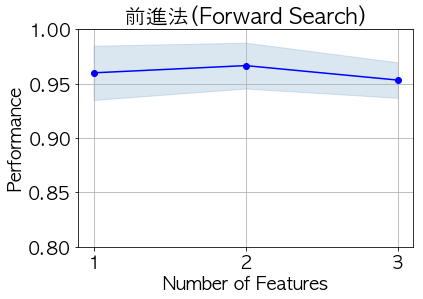

最終的に選ばれた3つの特徴
1 番目  sepal length (cm)
3 番目  petal length (cm)
4 番目  petal width (cm)


In [144]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


fig1 = plot_sfs(FS.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('前進法(Forward Search)')
plt.grid()
plt.show()


print('最終的に選ばれた' + str(K) + 'つの特徴')
for i in FS.k_feature_idx_:
    print(i+1,'番目 ',iris.feature_names[i])

In [145]:
X_selected = FS.transform(X)
X_selected[:5]

array([[5.1, 1.4, 0.2],
       [4.9, 1.4, 0.2],
       [4.7, 1.3, 0.2],
       [4.6, 1.5, 0.2],
       [5. , 1.4, 0.2]])

In [ ]:
FS = SFS(
        estimator=knn, 
        k_features=3,
        forward=True, 
        floating=False, 
        scoring='accuracy',
        cv=5
    )

pipe = Pipeline([
        ('sfs', FS), 
        ('knn', knn)
    ])

param_grid = [{
        'sfs__k_features': [1, 2, 3, 4],
        'sfs__estimator__n_neighbors': [1, 2, 3, 4]
    }]

gs = GridSearchCV(
        estimator=pipe, 
        param_grid=param_grid, 
        scoring='accuracy', 
        n_jobs=1, 
        cv=5,  
        refit=False
    )

## Sequential Forward Floating Selection (SFFS)
> *Forward Searchの亜種. アルゴリズムは取り込むことで評価が上がるものを含むところまで同じで、その後に削除すべき特徴があるか探す工程を追加している*
>
> *"逐次前進フローティング選択法"*

**アルゴリズムの参考文献**
> https://aotamasaki.hatenablog.com/entry/2018/06/14/235157#3-Sequential-Forward-Floating-Selection-SFFS

In [102]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


SFFS = SFS(
        knn,                             # 使う学習器
        k_features=3,           # 特徴をいくつまで選択するか
        forward=True,           # Trueで前進法(Forward Search)になる. Falseで後退法(Backward Elimination)
        floating=3,                # 3: SFFS, 2: SBFS, FalseでSFS, SBSのただ単に追加/削除していくアルゴリズムが実行される.
        verbose=0,               # 実行時のlogをどれだけ詳しく表示するか
        scoring='accuracy', # 評価指標
        cv=5                          # クロスバリデーション
    )
#ちなみにクロスバリデーションをしない(cv=0)とすると、最終的に選ばれる特徴が変わります。

SFFS.fit(X, y)

print(SFFS.subsets_)

pd.DataFrame.from_dict(SFFS.get_metric_dict()).T

{1: {'feature_idx': (3,), 'cv_scores': array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ]), 'avg_score': 0.96, 'feature_names': ('3',)}, 2: {'feature_idx': (2, 3), 'cv_scores': array([0.96666667, 0.96666667, 0.93333333, 0.96666667, 1.        ]), 'avg_score': 0.9666666666666668, 'feature_names': ('2', '3')}, 3: {'feature_idx': (0, 2, 3), 'cv_scores': array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 0.96666667]), 'avg_score': 0.9533333333333334, 'feature_names': ('0', '2', '3')}}


,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.96,0.0320608,"[0.9666666666666667, 0.9666666666666667, 0.933...","(3,)","(3,)",0.0249444,0.0124722
2,0.966667,0.0270963,"[0.9666666666666667, 0.9666666666666667, 0.933...","(2, 3)","(2, 3)",0.0210819,0.0105409
3,0.953333,0.0209887,"[0.9666666666666667, 0.9666666666666667, 0.933...","(0, 2, 3)","(0, 2, 3)",0.0163299,0.00816497


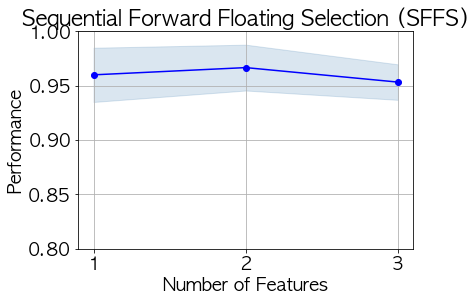

最終的に選ばれた3つの特徴
1 番目  sepal length (cm)
3 番目  petal length (cm)
4 番目  petal width (cm)


In [126]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


fig1 = plot_sfs(forward_search.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('Sequential Forward Floating Selection (SFFS)')
plt.grid()
plt.show()


print('最終的に選ばれた3つの特徴')
for i in SFFS.k_feature_idx_:
    print(i+1,'番目 ',iris.feature_names[i])

In [137]:
X_selected = SFFS.transform(X)
X_selected[:5]

array([[5.1, 1.4, 0.2],
       [4.9, 1.4, 0.2],
       [4.7, 1.3, 0.2],
       [4.6, 1.5, 0.2],
       [5. , 1.4, 0.2]])

## 後退法(Backward Elimination)
> 後退法では、まず全ての特徴を学習データに含めた状態からスタートします. そこから、精度の向上が一番大きくなるような、最も不要な特徴を1つずつ取り除いていきます。これを、精度の変化がなくなるまで反復的に繰り返します.
> 
> **貪欲後ろ向き選択**, **後向き漸次的選択法**(Sequential Backward Selection)とも呼ばれる.


> すべての特徴を含んだモデルから始める。もっとも重要でないと判断された特徴を削除していく。モデルのパフォーマンスが改善しなくなるまで削除を繰り返す。

In [133]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

K = 3

BE = SFS(
        knn,                             # 使う学習器
        k_features=K,           # 特徴をいくつまで削除するか
        forward=False,           # Trueで前進法(Forward Search)になる. Falseで後退法(Backward Elimination)
        floating=False,          # 3: SFFS, 2: SBFS, FalseでSFS, SBSのただ単に追加/削除していくアルゴリズムが実行される.
        verbose=0,               # 実行時のlogをどれだけ詳しく表示するか
        scoring='accuracy', # 評価指標
        cv=5                          # クロスバリデーション
    )
#ちなみにクロスバリデーションをしない(cv=0)とすると、最終的に選ばれる特徴が変わります。

BE.fit(X, y)

print(BE.subsets_)
pd.DataFrame.from_dict(BE.get_metric_dict()).T

{4: {'feature_idx': (0, 1, 2, 3), 'cv_scores': array([0.96666667, 0.96666667, 0.96666667, 0.96666667, 1.        ]), 'avg_score': 0.9733333333333334, 'feature_names': ('0', '1', '2', '3')}, 3: {'feature_idx': (0, 1, 3), 'cv_scores': array([0.93333333, 0.96666667, 0.96666667, 0.93333333, 0.96666667]), 'avg_score': 0.9533333333333334, 'feature_names': ('0', '1', '3')}}


,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
4,0.973333,0.0171372,"[0.9666666666666667, 0.9666666666666667, 0.966...","(0, 1, 2, 3)","(0, 1, 2, 3)",0.0133333,0.00666667
3,0.953333,0.0209887,"[0.9333333333333333, 0.9666666666666667, 0.966...","(0, 1, 3)","(0, 1, 3)",0.0163299,0.00816497


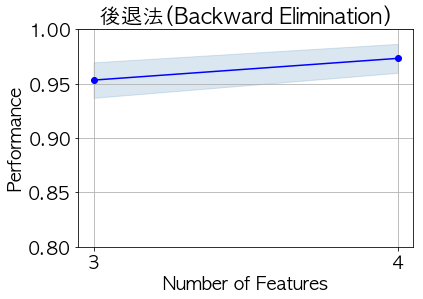

最終的に選ばれた3つの特徴
1 番目  sepal length (cm)
2 番目  sepal width (cm)
4 番目  petal width (cm)


In [134]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


fig1 = plot_sfs(BE.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('後退法(Backward Elimination)')
plt.grid()
plt.show()


print('最終的に選ばれた'+ str(K) + 'つの特徴')
for i in BE.k_feature_idx_:
    print(i+1,'番目 ',iris.feature_names[i])

In [136]:
X_selected = BE.transform(X)
X_selected[:5]

array([[5.1, 3.5, 0.2],
       [4.9, 3. , 0.2],
       [4.7, 3.2, 0.2],
       [4.6, 3.1, 0.2],
       [5. , 3.6, 0.2]])

## Sequential Backward Floating Selection(SBFS)
> 後退法(Backward Elimination)と同じようなもの. Sequential Forward Floating Selection (SFFS)は特徴追加していったが、これは削除していくだけである.

In [119]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


K = 1

SBFS = SFS(
        knn,                             # 使う学習器
        k_features=K,           # 特徴をいくつまで削除するか
        forward=False,           # Trueで前進法(Forward Search)になる. Falseで後退法(Backward Elimination)
        floating=2,                # 3: SFFS, 2: SBFS, FalseでSFS, SBSのただ単に追加/削除していくアルゴリズムが実行される.
        verbose=0,               # 実行時のlogをどれだけ詳しく表示するか
        scoring='accuracy', # 評価指標
        cv=5                          # クロスバリデーション
    )
#ちなみにクロスバリデーションをしない(cv=0)とすると、最終的に選ばれる特徴が変わります。

SBFS.fit(X, y)

print(SBFS.subsets_)
pd.DataFrame.from_dict(SBFS.get_metric_dict()).T

{4: {'feature_idx': (0, 1, 2, 3), 'cv_scores': array([0.96666667, 0.96666667, 0.96666667, 0.96666667, 1.        ]), 'avg_score': 0.9733333333333334, 'feature_names': ('0', '1', '2', '3')}, 3: {'feature_idx': (0, 1, 3), 'cv_scores': array([0.93333333, 0.96666667, 0.96666667, 0.93333333, 0.96666667]), 'avg_score': 0.9533333333333334, 'feature_names': ('0', '1', '3')}, 2: {'feature_idx': (2, 3), 'cv_scores': array([0.96666667, 0.96666667, 0.93333333, 0.96666667, 1.        ]), 'avg_score': 0.9666666666666668, 'feature_names': ('2', '3')}, 1: {'feature_idx': (3,), 'cv_scores': array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ]), 'avg_score': 0.96, 'feature_names': ('3',)}}


,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
4,0.973333,0.0171372,"[0.9666666666666667, 0.9666666666666667, 0.966...","(0, 1, 2, 3)","(0, 1, 2, 3)",0.0133333,0.00666667
3,0.953333,0.0209887,"[0.9333333333333333, 0.9666666666666667, 0.966...","(0, 1, 3)","(0, 1, 3)",0.0163299,0.00816497
2,0.966667,0.0270963,"[0.9666666666666667, 0.9666666666666667, 0.933...","(2, 3)","(2, 3)",0.0210819,0.0105409
1,0.96,0.0320608,"[0.9666666666666667, 0.9666666666666667, 0.933...","(3,)","(3,)",0.0249444,0.0124722


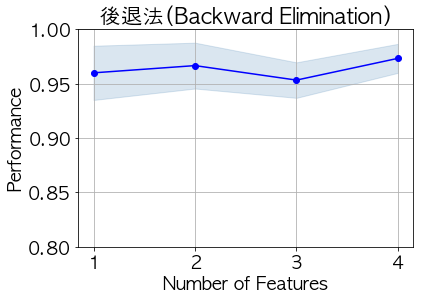

最終的に選ばれた1つの特徴
4 番目  petal width (cm)


In [124]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


fig1 = plot_sfs(SBFS.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('後退法(Backward Elimination)')
plt.grid()
plt.show()

print('最終的に選ばれた' + str(K) + 'つの特徴')
for i in SBFS.k_feature_idx_:
    print(i+1,'番目 ', iris.feature_names[i])

In [131]:
X_selected = SBFS.transform(X)
X_selected[:5]

array([[0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.2]])

## Recursive Feature Elimination
最高性能の特徴部分集合を探す貪欲なアルゴリズム。

> 変数減少法に近い実装として、sklern.feature_selection.RFE、および、RFEに交差検証を追加したRFECV(交差検証)があります。
>
> RFEは、変数減少法と同じく、最初に全ての特徴量を使ってモデルを構築します。 そのモデルの中で最も重要度の低いを特徴量を削り、性能を再計測するという処理を、指定数(デフォルトでは1)の特徴量になるまで繰り返します。 重要度の指標にはfeature_importancesやcoefが使われます。
>
> 乳がんデートセットに対して、分類器にSVMを使い、REFCV(5分割交差検証)で特徴量を削減する実装は以下のとおりです。
> 
> - ranking_には認識率が高くなる特徴量のランキングが昇順でセットされています
>    - つまり値が1となっている特徴量のみを使うと最も高い認識率となり、今回の例では14個だけで十分ということです
>    - プロットされたグラフを見てみても、特徴量数14の点で最も高い認識率(0.96)をマークしています

**パッケージ**
> [sklearn.feature_selection.RFE — scikit-learn 0.20.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)

In [170]:
# 例: RFE (Recursive Feature Elimination) を用いて、Support Vector Classificationモデルで各特徴量の重要度をランキングしたものです
# 値が小さいほど重要度が高いです。


from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# Load the digits dataset
digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

# Create the RFE object and rank each pixel
svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(X, y)
ranking = rfe.ranking_.reshape(digits.images[0].shape)

In [178]:
ranking

array([[64, 50, 31, 23, 10, 17, 34, 51],
       [57, 37, 30, 43, 14, 32, 44, 52],
       [54, 41, 19, 15, 28,  8, 39, 53],
       [55, 45,  9, 18, 20, 38,  1, 59],
       [63, 42, 25, 35, 29, 16,  2, 62],
       [61, 40,  5, 11, 13,  6,  4, 58],
       [56, 47, 26, 36, 24,  3, 22, 48],
       [60, 49,  7, 27, 33, 21, 12, 46]])

In [152]:
from sklearn.datasets import make_friedman1


X, y = make_friedman1(n_samples=50, n_features=10, random_state=0)

print(y.shape)
print(y[:5])
print(X.shape)
print(X[:5])

(50,)
[17.2134918  19.37965436 14.75030901 11.81662128  9.45520588]
(50, 10)
[[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548  0.64589411
  0.43758721 0.891773   0.96366276 0.38344152]
 [0.79172504 0.52889492 0.56804456 0.92559664 0.07103606 0.0871293
  0.0202184  0.83261985 0.77815675 0.87001215]
 [0.97861834 0.79915856 0.46147936 0.78052918 0.11827443 0.63992102
  0.14335329 0.94466892 0.52184832 0.41466194]
 [0.26455561 0.77423369 0.45615033 0.56843395 0.0187898  0.6176355
  0.61209572 0.616934   0.94374808 0.6818203 ]
 [0.3595079  0.43703195 0.6976312  0.06022547 0.66676672 0.67063787
  0.21038256 0.1289263  0.31542835 0.36371077]]


In [179]:
from sklearn.feature_selection import RFE  #  recursive feature elimination
from sklearn.svm import SVR


estimator = SVR(kernel="linear")
selector = RFE(
        estimator, 
        n_features_to_select=5,  # The number of features to select. If None, half of the features are selected.
        step=1
    )
selector = selector.fit(X, y)
selector.support_ 


selector.ranking_

array([60, 40, 42, 35, 31, 56, 38, 17,  1, 41, 15, 27, 26, 30, 28,  1,  1,
       50, 22, 25,  4, 34, 37, 11, 48,  7,  9, 23,  5, 18, 24,  1, 59, 10,
       44, 12, 45, 13, 49, 58, 55, 14, 57, 52,  8, 32, 54, 51,  2, 47, 46,
       19,  3, 33, 20,  6,  1, 29, 43, 16, 53, 21, 39, 36])

In [181]:
import pandas as pd
from sklearn.datasets import load_breast_cancer


dataset = load_breast_cancer()

X = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
print('X shape: {}'.format(X.shape))
# X shape: (569, 30)

y = pd.DataFrame(data=dataset.target, columns=['target'])
print('y shape: {}'.format(y.shape))
# y shape: (569, 1)

X shape: (569, 30)
y shape: (569, 1)


/Users/taiyou/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Feature ranking: 
[ 1  8  3 17  1  1  1  1  1 14 12  1  1  9 10  6  5  7 15 13  1  2 11 16
  1  1  1  1  1  4]
Rank 1 features: 
Index(['mean radius', 'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'texture error',
       'perimeter error', 'worst radius', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry'],
      dtype='object')


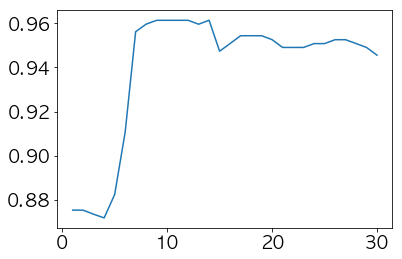

In [182]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV


# SVMによる分類
estimator = SVC(kernel='linear')

# 5分割交差検証
cv = StratifiedKFold(5)

# 特徴量削減
rfecv = RFECV(estimator, cv=cv, scoring='accuracy', step=1)

# 学習
rfecv.fit(X, y)

print('Feature ranking: \n{}'.format(rfecv.ranking_))
# 最も高い認識率となる特徴量14個
print('Rank 1 features: \n{}'.format(X.columns[rfecv.ranking_ == 1]))

# 特徴量数と認識率の変化をプロット
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

---
# 組み込み法(Embedded Method)
> 機械学習アルゴリズムの中で変数選択も同時に行ってくれる方法のこと。 具体的には、Lasso回帰, Ridge回帰, Regularized trees, Memetic algorithm, Random multinomial logitなどがある。


> 教師あり学習モデルを1つ用いてここの特徴量の重要性を判断し、重要なものだけを残す手法。特徴量選択に用いる教師あり学習モデルと最終的に使う教師あり学習モデルと同じでなくても良い。(RandomForestで特徴量の重要度を元に選択し、ロジスティック回帰で教師あり学習をする、など)

 - https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html
 - 別名: **モデルベース特徴量選択**

## 線形回帰
<font color="red">誤差項が正規分布だった場合に、有意性検定を行い、特徴選択が行える。</font>もし、誤差項が正規分布以外だった場合はこの方法は使えない。

## Lasso回帰
例: モデルとしてLassoを指定したSelectFromModel関数を使うことで、13個あった特徴量を7個に減らしています。sfm.get_support()の出力でFalseになっている箇所が削除された部分です (なお、SelectFromModelは係数が0じゃなくても閾値以下の係数の特徴量を削除することができます。)。

In [46]:
from sklearn.datasets import load_boston
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso


boston = load_boston()
X, y = boston['data'], boston['target']

lasso = Lasso(alpha=3)

sfm = SelectFromModel(lasso)
sfm.fit(X, y)
n_features = sfm.transform(X).shape[1]

print(sfm.get_support())
print('original features count: {}, selected features count: {}'.format(X.shape[1], n_features))

[False  True False False False False  True False  True  True  True  True
  True]
original features count: 13, selected features count: 7


In [183]:
from sklearn.datasets import load_boston
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge


boston = load_boston()
X, y = boston['data'], boston['target']

ridge = Ridge(alpha=3)

sfm = SelectFromModel(ridge)
sfm.fit(X, y)
n_features = sfm.transform(X).shape[1]

print(sfm.get_support())
print('original features count: {}, selected features count: {}'.format(X.shape[1], n_features))

[False False False  True  True  True False  True False False False False
 False]
original features count: 13, selected features count: 4


In [47]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel


iris = load_iris()
X, y = iris.data, iris.target
print(X.shape)

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
lsvc.fit(X, y)

sfm = SelectFromModel(lsvc, prefit=True)
X_new = sfm.transform(X)
print(X_new.shape)

(150, 4)
(150, 3)


## Ridge回帰

## ロジスティック回帰

## 決定木

## ランダムフォレスト